In [ ]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})
%config InlineBackend.figure_format = 'retina'
from IPython.lib.display import YouTubeVideo

# Week 6 (Monday), AST 8581 / PHYS 8581 / CSCI 8581: Big Data in Astrophysics

### Michael Coughlin <cough052@umn.edu>, Michael Steinbach <stei0062@umn.edu>, Nico Adams adams900@umn.edu


With contributions totally ripped off from Gautham Narayan (UIUC)

# Early Term Feedback Takeaways

### Homework / Mid-term

* There was a lot of encouragement to keep explaining as much as possible on homeworks, with clear improvement from the first few to the last few homeworks. We are very much trying to improve along these lines, including providing examples of what the final plots are to look like.

* On a related note, the mid-term next week is the exact same format as the homeworks, but instead they are to be done without help from your colleagues. We aim to make it a bit easier than a standard homework, given this fact. 
* *We are planning on turning next Wednesday's class into office hours where we will be available to meet with us about questions you have.* This is to help with the potential flow of questions at the usual office hours.

### In-class

* A *wide* variety of opinions on class structure: some people want more lecture, some more in-class warm-ups and some more time for the breakouts. This is hard and not an obvious right answer here. As we transition into machine learning (which starts next week), we expect more pedagogical lectures from Michael S. to improve the theory /statistics presentation beyond what we have gotten so far.

* We agree with the need for more introductory astronomy explanations; this will be a focus when prepping future lectures. 

* To support the HW better, we will try to provide stripped down examples of useful functions / libraries (like corner.py) to help introduce their use.

### Textbook

* Lack of a textbook also a concern. *Probably* next year we might try to Frankenstein a book together from available resources (although that becomes spendy :(. We will try to include as much foundational material as we can in the lectures for now (and point to free resources when we know of them / available).

### Final-Project

* To be clear, outside of some preparation (like soliciting ideas for the final projects, please do fill out here: https://forms.gle/RYugP8fdo22bo49M9) and perhaps a bit of preliminary reading, we do not plan to have overlap between the homeworks/mid-terms and the final project, which is set to begin a few weeks before the end of the course. 

* Once we have the topics, we will send out a form in which you will rank projects in order of preference, and will try to balance the groups by interest and corresponding skill sets from the self-assessment. We will include a space for requests for people you would like in your groups (but understand this is constrained by the previous requirement).


# Where do we stand?

Foundations of Data and Probability -> Statistical frameworks (Frequentist vs Bayesian) -> Estimating underlying distributions -> Analysis of Time series (periodicity) -> Analysis of Time series (variability)

# Last Class: Lomb Scargle

Pros:
- Works with unevenly sampled data, and binning in phase helps build statistics even with noisy data

Cons:
- ANY PERIODIC SIGNAL IN THE DATA WILL EXHIBIT SOME POWER
    - This includes aliases of the true period
- Multiband extension requires  that the period/frequency is the same across all channels/passbands 
    - this is not the case for many time-series phenomena

# Today: How do check if the object is even variable? Will try out emcee for sampling...

When dealing with time series data, the first thing that we want to know is if the system that we are studying is even variable (otherwise, there is no point doing time series analysis!).  

In the context of frequentist statistics, **this is a question of whether our data would have been obtained by chance if the no-variability null hypothesis were correct.**

If we find that our source *is* variable, then our time-series analysis has two main goals:
1. Characterize the temporal correlation between different values of $y$ (i.e., characterize the "light curve").  For example by learning the parameters for a model.
2. Predict future values of $y$.

If the errors are known and Gaussian, we can simply compute $\chi^2$ and the corresponding $p$ values for variation in a signal.

For a sinusoidal variable signal

# $$y(t) = A \sin(\omega t) + \epsilon(t)$$

where $\epsilon(t)$ (*error bars*) is normally distributed with mean 0 and constant errors, $\sigma$; then the variance is

# $$V = \sigma^2 + A^2/2$$

since $variance(sin(\omega t)) = A^2/2$ and is not dependent on $\omega$

*Try after class: confirm this property of variance = $A^2/2$ regardless of the $\omega$ chosen, given sinusoidal signal.*

# If $A=0$ (no variability)
* ### $\sum_j \left(\frac{y_j}{\sigma}\right)^2 $ is $\chi^2$ with $N$ degrees of freedom, mean $N$ and variance $2N$
* ### Thus, $\chi^2_{\rm dof}=\frac{1}{N} \sum_j \left(\frac{y_j}{\sigma}\right)^2$  has an expectation value of 1 and a std dev  of  $\sqrt{\frac{(2N)}{N^2}} = \sqrt\frac{2}{N}$

# If $|A|>0$ (variability)
* ### The expection of $\chi^2_{\rm dof}$ will be larger than 1.
* ### probability that $\chi^2_{\rm dof}>1 + 3 \sqrt{2/N}$  is about 1 in 1000 (i.e., $>3\sigma$ above 1)

If this **false-positive rate** is acceptable (even without variability, 1 times in 1000 we will observer a $\chi^2_{\rm dof}$ above this threshold) then the **minimum detectable amplitude** is:

### $$A > \left( \frac{72}{N} \right)^\frac{1}{4} \sigma \approx 2.9 \sigma N^{-{1 \over 4}}$$

which follows from equating $V/\sigma^2=1 + 3 \sqrt{2/N}$, expanding $V$, and solving for $A$.

### *Note: How many times do I need to observe a given point to be sensitive to variability of X?*
It takes $N > 70$ to reach $A=\sigma$.

For $N=100$ data points, the minimum detectable amplitude is $A=0.92\sigma$

For $N=1000$, $A = 0.52\sigma$ 

That is, **if we have enough observations, we can actually detect variability whose amplitude is smaller than the uncertainty in the measurements.**


Note that this is the best that we can do under the assumption of the null hypothesis of no variability.  

If instead we know the model (not limited to periodic variability), then we can perform a [**"matched filter"**](https://en.wikipedia.org/wiki/Matched_filter) analysis and improve upon this (i.e., we can positively identify lower-amplitude variability).  

**Indeed in a Bayesian analysis, we must specify a model.**

For non-periodic variability, the system can either be **stochastic** (like the stock market) or **temporally localized** (such as a flare/burst).

## Parameter Estimation, Model Selection, and Classification

Time series analysis can be conducted in either the time domain or the frequency domain. We'll use all the same machinery we worked with in the first half of class. 

We can fit a model to $N$ data points $(t_i,y_i)$:

# $$y_i(t_i) = \sum_{m=1}^M \beta_m T_m(t_i|\theta_m) + \epsilon_i,$$

where the functions, $T_m$, do not need to be periodic, $t_i$ does not need to be evenly sampled and $\theta_m$ are the model parameters.

So, for example, if we have

# $$y_i(t_i) = a \sin(\omega_0 t_i) + b \cos (\omega_1 t_i),$$

then $a=\beta_0$, $b=\beta_1$, $\omega_0=\theta_0$, and $\omega_1 = \theta_1$.

Determining if you have the right model can also use the same machinery as we've used (posterior predictive checks, information criterion):

Common deterministic models include

# $$T(t) = \sin(\omega t)$$

and

# $$T(t) = \exp(-\alpha t),$$

where the frequency, $\omega$, and decay rate, $\alpha$, are parameters to be estimated from the data.

You might also consider a "chirp" signal with

# $$T(t) = \sin(\phi + \omega t + \alpha t^2).$$

(another way of thinking of a chirp is that the *frequency varies with time*; $\omega_{\rm instantaneous} = \omega + \alpha t$)

## Temporally Localized Signals ($\S$ 10.4)

Let's begin with the case of a stationary signal with an event localized in time.
An example would be the signature of a [gravitational wave from LIGO](https://www.ligo.caltech.edu/news/ligo20160615).


<table>
    <tr>
            <td><img src="figures/small_multiples.png" width=100%></td>
    </tr>
</table>

In this case we know the expected shape of the signal and the noise properties are understood, so we can do what is called *forward modeling*.  Specifically, we will identify the signal by using a **matched filter** (with MCMC to search for the parameter covariances).

Even if we didn't know the shape of the distribution, we could use a non-parametric form to perform matched filter analysis.  Furthermore, for complex signals we can marginalize over "nuisance" parameters (e.g. start time or phase) that are not important for our model.

# Modeling a time-series when we have a forward model

### In the first half of this class, we were able to write down a nice parametric model for our observations

### However, precisely because time is an exogenous variable - just a counter that we happen to record along with our measurements - we can't usually do that anymore. 

### A notable exception is for periodic phenomena, where while the time stamp is not important, there are characteristic time-scale that we can use to build a model

### The best example of this is radial velocity experiments used to detect exoplanets


<table>
    <tr>
            <td><img src="figures/Radial-Velocity-Method-star-orbits.png" width=100%></td>
    </tr>
</table>

### Here, the behavior of the system is governed by Kepler's laws and there is a honest-to-goodness parametric model to describe the observations. 

For understanding the orbital equations, the following webpage is useful:
https://www.classe.cornell.edu/~seb/celestia/orbital-parameters.html 

### You can write down simple models to describe the milk production of cows, and while it is true that any cows you launch will also obey Kepler's laws, there's no fundamental physics that governs their milk production (which is likely to cease in short order if you do actually test bovine adherence to Kepler's laws). 

### While the radial velocity method is expensive, because we can build very high resolution spectrographs (remember these are just devices that are mapping energy differences into angular separation), they're likely our best hope for finding an Earth-like exoplanet. 

# EMCEE: A cascaded affine invariant ensemble MCMC sampler. "The MCMC hammer"

This is an implementation of the Goodman and Weare 2010 Affine invariant ensemble Markov Chain Monte Carlo (MCMC) sampler. The problem with many traditional MCMC samplers is that they can have slow convergence for badly scaled problems, and that it is difficult to optimize the random walk for high-dimensional problems.
This is where the GW-algorithm really excels as it is affine invariant. It can achieve much better convergence on badly scaled problems. It is much simpler to get to work straight out of the box, and for that reason it truly deserves to be called the MCMC hammer.

# In Class Exercise - Looking for planets

In [2]:
# RUN THIS
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn; seaborn.set() #nice plot formatting
import pandas as pd
import corner
from collections import namedtuple
from scipy import optimize
from gatspy.periodic import LombScargleFast
import emcee

In [3]:
# RUN THIS
data = pd.read_csv('data/47UrsaeMajoris.txt', delim_whitespace=True)
t, rv, rv_err = data.values.T

### Data

Visualize this data

<ErrorbarContainer object of 3 artists>

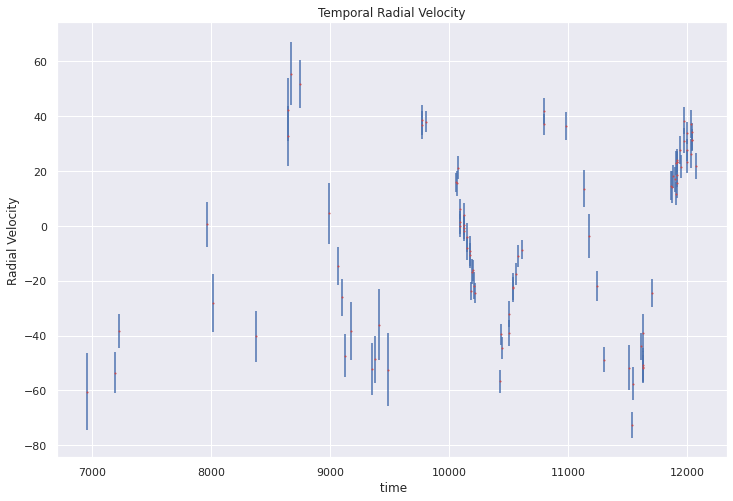

In [7]:
# YOUR CODE HERE
# Create a figure environment and define the size using the figsize argument
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111, title='Temporal Radial Velocity',xlabel=" time",ylabel='Radial Velocity') #set title and axis labels here
ax1.errorbar(t,rv, rv_err,marker='o',ms=1,mfc='r', mec='r',linestyle='')

### The Model

The first important step is to define a mathematical (and computational) model of how the parameters of interest are reflected in our observations.

Some references relating to what we're going to compute below:

- Balan 2009: http://adsabs.harvard.edu/abs/2009MNRAS.394.1936B
- Exofit Manual: http://www.star.ucl.ac.uk/~lahav/ExoFitv2.pdf
- Hou 2014: http://arxiv.org/pdf/1401.6128.pdf

The equation for radial velocity is this:

$$
v(t) = V - K[ \sin(f + \omega) + e \sin(\omega)]
$$

where $V$ is the overall velocity of the system, and

$$
K = \frac{m_p}{m_s + m_p} \frac{2\pi}{T}\frac{a \sin i}{\sqrt{1 - e^2}}
$$

The true anomaly $f$ satisfies

$$
\cos(f) = \frac{\cos(E) - e}{1 - e\cos E}
$$

Rearranging this we can write
$$
f = 2 \cdot{\rm atan2}\left(\sqrt{1 + e}\sin(E/2), \sqrt{1 - e} \cos(E/2)\right)
$$

The eccentric anomaly $E$ satisfies
$$
M = E - e\sin E
$$

and the mean anomaly is
$$
M = \frac{2\pi}{T}(t + \tau)
$$

and $\tau$ is the time of pericenter passage, which we'll parametrize with the parameter $\chi = \tau /  T$

These are the parameters needed to compute the radial velocity:

- $T$: orbital period
- $K$: amplitude of RV oscillation
- $V$: secular offset of RV oscillation
- $e$: eccentricity
- $\omega$: longitude of periastron
- $\chi$: dimensionless phase offset

Additionally, we will fit a scatter parameter $s$ which accounts for global data errors not reflected in the reported uncertainties (this is very similar to the third parameter from the linear fit we saw earlier)

For convenience, we'll store these parameters in a ``namedtuple``:

In [8]:
# RUN THIS
params = namedtuple('params', ['T', 'e', 'K', 'V', 'omega', 'chi', 's'])

### These just define the model we wrote down

In [35]:
# RUN THIS

@np.vectorize
def compute_E(M, e):
    """Solve Kepler's eqns for eccentric anomaly given mean anomaly"""
    f = lambda E, M=M%(2*np.pi), e=e: E - e * np.sin(E) - M
    return optimize.brentq(f, 0, 2 * np.pi)


def radial_velocity(t, theta):
    """Compute radial velocity given orbital parameters"""
    T, e, K, V, omega, chi = theta[:6]
    
    # YOUR CODE HERE
    M = 2*np.pi/T *(t+chi*T)
    E = compute_E(M,e)
    arg1 = np.sqrt(1+e)*np.sin(E/2)
    print(e)
    arg2 = np.sqrt(1-e)*np.cos(E/2)
    f = 2*np.arctan2(arg1, arg2)
    return V - K*(np.sin(f+omega)+ e*np.sin(omega))

In [36]:
#t_test = np.linspace(6000,13000,1000)
#rv_model = radial_velocity(t_test,params)

The equation for radial velocity is this:

$$
v(t) = V - K[ \sin(f + \omega) + e \sin(\omega)]
$$
where $V$ is the overall velocity of the system, and

$$
K = \frac{m_p}{m_s + m_p} \frac{2\pi}{T}\frac{a \sin i}{\sqrt{1 - e^2}}
$$

The true anomaly $f$ satisfies

$$
\cos(f) = \frac{\cos(E) - e}{1 - e\cos E}
$$

Rearranging this we can write
$$
f = 2 \cdot{\rm atan2}\left(\sqrt{1 + e}\sin(E/2), \sqrt{1 - e} \cos(E/2)\right)
$$
The eccentric anomaly $E$ satisfies
$$
M = E - e\sin E
$$

and the mean anomaly is
$$
M = \frac{2\pi}{T}(t + \tau)
$$

and $\tau$ is the time of pericenter passage, which we'll parametrize with the parameter $\chi = \tau /  T$

### The Likelihood and Priors

In [43]:
# RUN THIS

theta_lim = params(T=(0.2, 2000),
                   e=(0, 1),
                   K=(0.01, 2000),
                   V=(-2000, 2000),
                   omega=(0, 2 * np.pi),
                   chi=(0, 1),
                   s=(0.001, 100))
theta_min, theta_max = map(np.array, zip(*theta_lim))

def log_prior(theta):
    # UNIFORM PRIOR FOR ALL PAREMETERS
    '''
    test1 =  np.any(theta > theta_min) 
    test2 = np.any(theta < theta_max)
    test  = np.where(test1 and test2, True,False)
    return np.where(test, 0, -np.inf)
    '''

    if np.all((theta_min < theta) & (theta < theta_max)):
        return np.log(1)
    else:
        return -np.infty #np.log(0) 
    

def log_likelihood(theta, t, rv, rv_err):
    # YOUR CODE HERE
    model = radial_velocity(t, theta)
    chi2 = np.square(rv - model)/np.square(rv_err)/(len(t)-6)
    return -0.5*np.sum(chi2)

def log_posterior(theta, t, rv, rv_err):
    ln_prior = log_prior(theta)
    if np.isinf(ln_prior):
        return ln_prior
    else:
        return ln_prior + log_likelihood(theta, t, rv, rv_err)

###  Now use LombScargle output as initial guess and sample the model

In [44]:
def make_starting_guess(t, rv, rv_err):
    model = LombScargleFast()
    model.optimizer.set(period_range=theta_lim.T,
                        quiet=True)
    model.fit(t, rv, rv_err)

    rv_range = 0.5 * (np.max(rv) - np.min(rv))
    rv_center = np.mean(rv)
    return params(T=model.best_period,
                  e=0.1,
                  K=rv_range,
                  V=rv_center,
                  omega=np.pi,
                  chi=0.5,
                  s=rv_err.mean())

theta_guess = make_starting_guess(t, rv, rv_err)
theta_guess

# Run emcee
# Read https://emcee.readthedocs.io/en/stable/ for example

ndim = len(theta_guess)  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers

# start with a tight distribution of theta around the initial guess
rng = np.random.RandomState(42)
starting_guesses = theta_guess * (1 + 0.1 * rng.randn(nwalkers, ndim))

# RUN MCMC - YOUR CODE HERE
sampler = emcee.EnsembleSampler(nwalkers,ndim,log_posterior, args=[t,rv,rv_err])
nsamples = 1000
sampler.run_mcmc(starting_guesses,nsamples)

0.09861735698828816
0.09530525614065048
0.09437712470759028
0.10067528204687924
0.09708306250206723
0.10208863595004757
0.09698896304410712
0.10324083969394796
0.09690787624148786
0.10812525822394199
0.1153803656646597
0.10091760776535504
0.09498242956415465
0.09297946906122648
0.09765412866624854
0.11886185901210532
0.12463242112485287
0.10791031947043046
0.09433702270397229
0.09080575765766197
0.11307142754282429
0.10521941565616898
0.09285648581973632
0.11158595579007405
0.0924626383564251
0.10013001891877907
0.10482472415243185
0.0955348504793298
0.10153725105945528
0.0862233063204291
0.11135565640180599
0.09514636452170898
0.11088950596967367
0.10045571839903814
0.10852433334796224
0.09525054688839045
0.11032465260551148
0.09073069528421918
0.08569858622039367
0.0901849134895205
0.10662130674521048
0.10280991867735033
0.09307090404739346
0.10747293605123263
0.09797807347566106
0.10681952971294964
0.12092387275685462
0.09987753227153086
0.09678614158347007
0.09528961694381677
0.100

0.1051311456864668
0.10917006480303303
0.09098348650965206
0.0980039242527424
0.07613555356580004
0.12789863868448373
0.09156611144668697
0.10624868355991986
0.13975193194584062
0.1145951385669791
0.09277796246194887
0.10777066334901855
0.0764658152281948
0.08617548338125915
0.10889187540638315
0.1101556319349543
0.09934841214336745
0.10604378005678779
0.10625888124835274
0.10619058487421863
0.11016570367028235
0.1171441118289514
0.09712774863244635
0.10444007331308627
0.10207849798374054
0.09398521939410119
0.10214313960069435
0.10545416987540715
0.07809776632303109
0.08825603592500653
0.08998559383984805
0.10333881405787287
0.14232455374518982
0.10701090965337536
0.0998304248710316
0.06688265841434124
0.09889522772114935
0.11293760378173179
0.11455010273291236
0.09003451696695004
0.07598321563229497
0.072660107409948
0.11737663812036322
0.09822577503807338
0.06640979067199872
0.11480964375767336
0.09787226036255972
0.10753416568208252
0.10893045241905805
0.09724539290329902
0.1030351

0.09644053926682157
0.10611757523580871
0.14162524419928393
0.053798792467311035
0.1625223390714084
0.0998165636426304
0.08526265263183969
0.08798958763635908
0.09597561271251995
0.10920509537535958
0.1075606246012599
0.10521476655849954
0.10111705886266761
0.10199486523857887
0.11542488428684318
0.1156096479617652
0.09243133947738154
0.0704005875553618
0.08817989497402268
0.1034932150705247
0.08389617892987421
0.09445873507765348
0.10210571146793786
0.08708213362751756
0.08977878543263777
0.10785676451678379
0.09731313551633904
0.10127977216894768
0.0653734835860976
0.09399396212167391
0.10179822207722938
0.15640458219835005
0.08964204575446821
0.10279976837274651
0.08235700683775446
0.11051219147426253
0.09416074167718332
0.10331324559450726
0.12835862107522203
0.1410865782834226
0.09939450620085424
0.10242648710133789
0.08745118666988472
0.10124947615240192
0.02843613671464129
0.1449011571700812
0.09082843143080989
0.12135270317800143
0.1331103887217093
0.09434482439814573
0.1090042

0.087723973151955
0.1227438716393549
0.10495238581423039
0.09675000468431433
0.11937224308958583
0.12872092300191573
0.08751629845319236
0.11399600116066547
0.10988923066677184
0.09574614539686296
0.0624402876408297
0.10814575696909697
0.1432312561029544
0.09628110044563498
0.11957599362742012
0.09960760304299435
0.10118848093622117
0.10409633837610542
0.10260224362551551
0.09697477587034735
0.12028397071023957
0.10541876489478907
0.11803950010405033
0.14865274230875067
0.09480008652715227
0.08701870855489637
0.0898665841595483
0.11492467432664083
0.09526767793975528
0.10258824884201323
0.09152148693402154
0.102822136650632
0.09184364071436345
0.09746735438621931
0.10573147862939221
0.10092555064999076
0.061256481831052784
0.06567515494597113
0.09388297464744863
0.13833662046509995
0.08534694628246298
0.11999722350014143
0.08683400526682011
0.11681550686722768
0.1037914654770397
0.09990366885831399
0.120182079319388
0.14418635463486207
0.10877031879411406
0.12396742429378704
0.11445715

0.09238373600838815
0.09979611796148155
0.1076949656280101
0.11045451070603736
0.07690050613340788
0.08151395935932823
0.12386117232821711
0.09510981930419679
0.0972360222852098
0.08323202794451078
0.11097900734453482
0.10998857145257186
0.11710693100893331
0.11518226540703477
0.09497641001886406
0.11666520405130487
0.0890116417572019
0.07650985300413411
0.14005245639759165
0.06971010410186843
0.11379593979765959
0.08681368283414982
0.14340522168427022
0.10376819888703823
0.1071256149259657
0.1315073154745366
0.13868771006539513
0.10056511776840792
0.1091084198786164
0.10979645388830044
0.15013491028276468
0.0243750440522352
0.07778345436637404
0.10452874899995832
0.15612882654091204
0.1467596070150302
0.03489344860383742
0.12257036631215519
0.07460255878629705
0.11118832215569227
0.0913134882307678
0.0951844000432442
0.09740872675101686
0.09391274975869354
0.09981195629239578
0.10759423187063638
0.11285568879247865
0.17708701455002268
0.1234446694078142
0.09252200612423739
0.070626374

0.1291679180849725
0.09379397244694494
0.18822001148676262
0.0904047283814132
0.10219468647918574
0.0998639691108956
0.09094196069163071
0.06696043919693719
0.0544604926387783
0.09450169475960038
0.17870600569426004
0.137779038609108
0.1058055803756146
0.2051711399790374
0.13077354369554509
0.09384584328750874
0.09564273572879886
0.11690573001349862
0.12022367140472981
0.0881997550885536
0.13844967973284367
0.0014622708221718461
0.11107191785597412
0.1359425440688782
0.061655945288677516
0.13726738756460205
0.07957863992521608
0.047905201928231805
0.13287606233106813
0.1098025557047296
0.11086999249886342
0.0913509989559575
0.05103240705724393
0.1081042394041605
0.06952484352322073
0.14546485153086278
0.09572031335850803
0.12923853421294124
0.1036516670534445
0.11303821640266852
0.10940910741232299
0.0948794647887265
0.10182585531662364
0.09977808434959043
0.0772431432958316
0.08033007368754211
0.10574567896228645
0.18822289965415895
0.09465046212818179
0.09775666522773198
0.1618363641

0.0878855684918528
0.09008722833294111
0.11268832076174819
0.05412319322208253
0.011844224206346302
0.1322917509777357
0.07418640539634112
0.11827919164649708
0.11745662527710087
0.13491088331787268
0.12992181211070936
0.0958356686651265
0.06017971204855432
0.11838246679835635
0.05555454333230325
0.15792553183025693
0.11726343816932791
0.11769995030892388
0.14318891840737655
0.09024259937560228
0.09427773866289088
0.11383302929944741
0.10850587261482975
0.12895666324945507
0.19584227862300288
0.1183549094858595
0.19475354045572252
0.05607715538354158
0.08111257348763204
0.052373287224680834
0.13628691720836184
0.0900675964129534
0.10813272202865984
0.044187302669334905
0.07770645772091948
0.14384001083828152
0.12238518719658292
0.17801725476568458
0.061315884647644064
0.08442375457485596
0.08817345646094338
0.07435070737164892
0.1273807533806765
0.07906958178304493
0.20704184524726787
0.10125204391907489
0.131620108068444
0.13141054278690442
0.12838397138447097
0.08898174414187494
0.08

0.1351820921934637
0.05992010563817767
0.03328785156432604
0.0573179103165887
0.060982065360491444
0.14616200618445396
0.14184825530485196
0.08948384564394997
0.07491906253427814
0.12417872976885896
0.09682325625958864
0.08030062712726745
0.07545524259153069
0.11677881975680005
0.09183294683344487
0.08605168541675155
0.061033114115656206
0.16162653820418746
0.12348683083678469
0.15550193998802447
0.13244778458590437
0.0997960573205577
0.07715626809878665
0.07851307821162065
0.11406668022016114
0.11067792890514055
0.17136483593173568
0.12140738385291992
0.124591295318926
0.03362329718375538
0.06960210094571015
0.13413185196476873
0.0591875850276205
0.09384646504899868
0.10069302280519252
0.06831773568139629
0.13849440976004015
0.07145330848232939
0.11607853049403921
0.07673085232901364
0.10301871212205892
0.0457418050392384
0.1169841524699202
0.14040599620316427
0.1223592532738455
0.08494357238664213
0.08634300321967411
0.11707315787353326
0.07432241253931761
0.07981086875890929
0.06250

0.08745899204606923
0.10054224716149718
0.08594133852229993
0.03337288311840662
0.10565460163546815
0.09436974718425195
0.06376269420728106
0.025564606108570406
0.12963725165575307
0.12417789513172506
0.06578666591116866
0.12757490238681302
0.11717351971105443
0.11302866956985955
0.10749375138904194
0.08602951294008251
0.05521174535094711
0.11749029973811553
0.04717541570455183
0.07543148638340004
0.0018953375964980146
0.15944168057371505
0.11639240903636601
0.14002906767559273
0.03864976208188106
0.05918158070887582
0.08398757479555191
0.12292413881537721
0.11759737764113179
0.1117225447268791
0.11261855138619402
0.07180990629383167
0.09200625475630936
0.045980330661920366
0.3744164179544478
0.11767533772750657
0.07923500004063924
0.0842120022634521
0.0848089132604148
0.06264037866718308
0.11008185156062304
0.05463880290419236
0.04817233072957748
0.0878095422078995
0.06855857562872253
0.1432512574023773
0.10655637246315382
0.10440318256598206
0.07768861332060586
0.08196573130035108
0.

0.08029517342757127
0.12989007233418542
0.11608525426662375
0.14399250431279728
0.07065155972573714
0.017146455142261055
0.0561258317537703
0.09816874800772248
0.09122836329299625
0.09222257446690593
0.10840794856649222
0.12224065613923393
0.01927839763303163
0.11222308913590148
0.24954307323529723
0.05999338581618148
0.03679112211595131
0.09409961179949662
0.11284076316907021
0.06948863481137346
0.05602365073883745
0.08516393863024892
0.06533401144397037
0.10854797602643515
0.15056565688594986
0.07805066059816859
0.12195120770053518
0.11025461216589087
0.10369918479210177
0.15229406596270417
0.07525793807995326
0.04733066392121168
0.10637880435435018
0.08790463816037591
0.06530854492149549
0.11370468091355956
0.1356552070150236
0.10918033219060158
0.15853028587782433
0.06440385096245764
0.0659184525977198
0.07837660413161407
0.08005402223977581
0.09748991720657976
0.13635750410110797
0.13765817753207538
0.22420909775629733
0.026387962909332083
0.07001341301144269
0.11473784484330579
0

0.09117576487661092
0.009403871173649325
0.13954099451870872
0.1130457358173855
0.1486746826942211
0.09323209439038269
0.16669940771451464
0.0034429515844254105
0.06137773610164412
0.09497873368170093
0.0906792808710597
0.02497649496820887
0.10127032591123203
0.09164526273547785
0.1372999678980228
0.12348771384686306
0.12722881887365745
0.14341561190117078
0.1222999772178038
0.22231760725701116
0.3139753317350049
0.12532645456137678
0.06288620168128274
0.08133426381652253
0.04610492643940381
0.062453923594532015
0.07767200913517092
0.06749935090971565
0.04808482420849494
0.07085892827647366
0.21190962242528416
0.10462522223053611
0.008509794216331135
0.03917850113449693
0.11002682891008565
0.0905066781360283
0.03299344976682518
0.15374117809388382
0.1126880523820142
0.102546200263154
0.20311477602624928
0.045923735936224175
0.10104613467436395
0.07785572843922378
0.018084558998791286
0.1426346618460122
0.13918144683839623
0.12196141760852482
0.11869237107708426
0.15649749279122976
0.12

0.09282895446076476
0.11520868429644643
0.1304009217406205
0.2062436278243417
0.07974322827865796
0.09057403264663438
0.10989333906254614
0.051616788635006454
0.05872479666220659
0.092645241121747
0.09322995046982738
0.2206930539125114
0.23850574109355066
0.05064651100650221
0.1114422432823135
0.1711382399180842
0.06822902340166528
0.02964894475501162
0.07913288698046736
0.034501695658897005
0.06154190710419053
0.06395329881472087
0.11372513909062569
0.1307389320973731
0.08871644538991301
0.07558409007546052
0.0705743215693195
0.03155352891141794
0.1563647221519174
0.22640174387054623
0.08490416561951113
0.04876930760609384
0.10318668153474568
0.0713600641113907
0.0696533638709296
0.12512272163534643
0.048699818707968884
0.06862939679382203
0.1769968598797741
0.22927606720545501
0.055594031367616446
0.0867111938976203
0.1766086851685048
0.023832225189683198
0.30238865100540147
0.15226774262832798
0.068929515075393
0.08922100127304797
0.0028187809725823826
0.10998927213364781
0.08156618

0.13651901980539327
0.16752622801786965
0.23545891850995757
0.051111201957898963
0.14102749727068892
0.035469287145960406
0.022094166089916798
0.10196015956159189
0.03510873818425804
0.09889831623623607
0.0564833451110236
0.09754756422533165
0.0538974192238314
0.13034718699961756
0.03769730457037959
0.050059800885720485
0.15483181927296186
0.09301640927863271
0.24086740580383392
0.0508080975767377
0.05534254980311486
0.07651586105642275
0.046761946148485646
0.18389830470975033
0.12047104555921823
0.06839698147997361
0.11201623291207524
0.06492050790554009
0.1795317474293547
0.07523829169046971
0.05037630899736621
0.21607828699190731
0.3177646251556363
0.020017604582422428
0.09392649712460877
0.009238847123722319
0.17952324281278031
0.05555677868851222
0.04783993146872913
0.08960047739303098
0.1556316704024119
0.11194587110461252
0.11729174702518572
0.09495102875424809
0.07017048370100293
0.09019762502769854
0.032504787978705034
0.11584822301401235
0.11544647033353621
0.0765928070593530

0.13745688354907926
0.15642373493741027
0.06361532625249244
0.06111471965263596
0.03541935767995935
0.11756671534778955
0.041015267998134874
0.14299056401512514
0.14144517395652395
0.2013223009488562
0.09377078027035265
0.3170685776785567
0.07223423859166506
0.06758613127632032
0.10028114742552661
0.025402341640704644
0.12131748321394195
0.0036544243355877137
0.04527367363680458
0.13579231290740448
0.07042049057388852
0.08884706777566287
0.1375771484942414
0.1941329066534242
0.10745014538476295
0.014560444606843193
0.22148785266209103
0.07601259648891356
0.08427464786351058
0.06094248291922442
0.07279748804703867
0.010927456214472615
0.10928855959488278
0.027053657296670204
0.006263280916405146
0.09155319944112698
0.07336366892895213
0.2891919602197494
0.11907778451142571
0.1568928335039073
0.1032281517691029
0.10967083808783812
0.04416188318919241
0.05572737012414888
0.1791021136446887
0.10424492841404101
0.11707358028653242
0.08316349266586615
0.027991314742351198
0.06786955716322765

0.05832991078739644
0.07384404233805453
0.06582047210137205
0.0262557241921532
0.12227575994161838
0.15325962205620508
0.2539470686171586
0.2993371780562603
0.09231654121174701
0.01810175203290232
0.025528478414562395
0.1648120643001525
0.18779571179669474
0.08082330922848721
0.08015771891885938
0.06213505131564662
0.09110408986294939
0.10628815796461877
0.041522374828881846
0.05384119782583685
0.14469812233271384
0.0846399913693534
0.20954723910127718
0.17318738248293725
0.12128825170067362
0.11557346717954185
0.0990233616764503
0.048757840312172215
0.10259471069630058
0.14654246839972235
0.11060768592264592
0.07642856716126542
0.06073330874840582
0.09366389239332942
0.18443117681407045
0.09466499717503875
0.08007022047477466
0.08835814891217106
0.12651858282689904
0.17398483604142978
0.07775087970674871
0.24112274618321117
0.10928160578858628
0.01961435533802062
0.28815504398451386
0.08359983445519335
0.08010797887693104
0.06690599930104313
0.09165630804223503
0.0005386196967085699
0

0.2221997830850306
0.1675474161131974
0.1702684200508248
0.43738456200626635
0.08732180475758018
0.07212812036124489
0.03682291240375632
0.09339216483594498
0.12417343976903016
0.2104010384351322
0.0590494612876596
0.10939849855322757
0.1663902780704534
0.07581120882213224
0.18375323753543044
0.09192059433048047
0.03353027182345898
0.1149785913057584
0.06596015120889749
0.1389582964617551
0.16585686581174922
0.1876004066971247
0.1835294907134835
0.1614224912611497
0.034248840871865666
0.037085111641649585
0.05826336411310082
0.01844566641646342
0.11066455519657847
0.12327785931591649
0.0692862941908835
0.14853453699885624
0.16765636296430797
0.12213738448467158
0.21870756759640717
0.2606824095454989
0.12108989797305239
0.05073150668273439
0.12322432197209204
0.07818725780128483
0.018513213373137508
0.03365896747420253
0.06495074808619278
0.07044345505008065
0.12180812488008312
0.18671959091511237
0.07171739916825257
0.18131598510834562
0.1359379977404489
0.13545196140095583
0.116117436

0.11618555060820517
0.11021398570700065
0.07204143147812433
0.14553232946817876
0.15248226780100685
0.08402797136064608
0.13082492068371548
0.26478485537572105
0.2616024798400127
0.10248779470676377
0.11678217852736933
0.06280839058966227
0.13650969129441448
0.12826350236586676
0.028583395122300292
0.08784358168944946
0.1575085858502376
0.25030938650614254
0.164025915422732
0.4154652088907856
0.29772579759870643
0.045468089478927214
0.1368026135540589
0.10469824945854521
0.10692619397002787
0.034690365917226275
0.1686462984307593
0.00239194356047151
0.14370515600235467
0.18708150486711153
0.1295466532394078
0.016424854278715734
0.07738108407947615
0.11410212373394851
0.1333312580625916
0.034603409565659896
0.07546221721807596
0.09048562557804425
0.14283483501238686
0.1443907293071208
0.08291972680746876
0.16305133967708077
0.21492708132996746
0.0942050585420026
0.0688321622410529
0.10273553905022972
0.05284680777506663
0.07535799220303799
0.2173304005648586
0.08346115206496588
0.211143

0.1793397423692178
0.06140776302260653
0.18419838590482207
0.14044641574745348
0.06378813589876647
0.15807189565363175
0.12359466212938375
0.440166502577343
0.2800525889909648
0.04552210188751285
0.12544211873856342
0.1928555050696325
0.13934646357118435
0.09278776215547097
0.09961055260397356
0.1001845952287436
0.07074058598528488
0.027144108539810075
0.12119356439794084
0.17094533682448576
0.12306084881357442
0.16565409590696956
0.037157269146199635
0.11038013239683624
0.06048673747032937
0.3165683243605541
0.1364855115443213
0.2785296399518102
0.18031422649751536
0.21971079166072865
0.07546978589097528
0.07318883432296235
0.07366731051770611
0.10389311318633286
0.052290129108956
0.06378986616219741
0.20136464035225277
0.03788093478687103
0.14376751160855025
0.15162024090476664
0.03765532306622807
0.12876120701256877
0.11747789745808113
0.1655490795019333
0.16964504107847675
0.2736307536741839
0.2904039483421997
0.1452946414003395
0.12348154335248779
0.1484101347023976
0.077221446711

0.037351982036891634
0.09330017891312076
0.5766835432810923
0.20060192901649163
0.2482975109169209
0.04511513532161408
0.07218779389258417
0.1330656023610324
0.08869734356547414
0.03591759146995409
0.16844858184171402
0.1872082748590424
0.41308901734528136
0.2900096534801232
0.04620328150422781
0.10975005612461933
0.1674245018731017
0.08870662801596416
0.12271733957835262
0.1679705081018568
0.10005794220270742
0.023321420700673383
0.1164188162300269
0.1694866693903595
0.06481374934560302
0.08222393893587421
0.265539982973883
0.1610906097567972
0.06485585094467261
0.127676888915412
0.3665372522450248
0.2647785213973835
0.14466616330015497
0.27573237015926905
0.1619130458266399
0.24391481118377256
0.05347361963998555
0.15062501550091145
0.07750531968696829
0.02605312123906592
0.12247856877428788
0.09606458008760986
0.07490126972746078
0.0012333773826129074
0.18795494911543514
0.15568370296110914
0.4167479433910968
0.14676018652272288
0.23095783281437376
0.13817291842315804
0.078784137764

0.348344052081714
0.11279610538354928
0.18647055522124728
0.05527924806791045
0.10256303266401137
0.11657149384299287
0.029671590239159343
0.1574523698091122
0.07214954959082884
0.09524427533153965
0.18029452137115554
0.0847529136492215
0.12026893129461831
0.2819607013462284
0.24682046841982747
0.12281543575913466
0.14350080775379268
0.0898535778471434
0.07651167925007016
0.11779189998812156
0.24906040733388532
0.1155469624146942
0.07830838664948395
0.1525776957701304
0.10282057404764772
0.1176917968663933
0.22974546205915308
0.14382651909351785
0.1462597531687547
0.09245747594968741
0.27798446605142124
0.19686001321706115
0.10451282620732816
0.04450846894856271
0.11005725988303681
0.2474355985420252
0.15273882964611302
0.15727284552744192
0.31259375335235995
0.12173482854106511
0.1344983822543627
0.12782677079525342
0.0936413891801512
0.1396647419520017
0.08086367764144778
0.16574585011583767
0.08372412735656076
0.11082226149397062
0.11330810840329586
0.1480532479090267
0.222099423381

0.2277804716157934
0.2044565233171875
0.3218574350981579
0.31799363748572906
0.07829219604803847
0.0661449750424811
0.07270820879935902
0.14225039619488045
0.17368932711515855
0.12678012753837944
0.09925650629382687
0.10481447114378335
0.18419224553115998
0.19909171043884433
0.1929635668237708
0.16814762700533897
0.09276930823886492
0.15540080564142555
0.0555795181683872
0.12591792551091863
0.11673695737053767
0.6924080588592164
0.29483438465970147
0.20163346526211956
0.21400082882273008
0.17571200428447153
0.14327224628979415
0.08369553740575089
0.21828930788036172
0.07712699923928672
0.16241554579010448
0.07713909523045492
0.13596474574297385
0.1553911461239176
0.14497366471388673
0.19678084123514428
0.07395386017534779
0.1108455292103297
0.12637723558224326
0.05844500466151153
0.27679970869668324
0.0739435948633125
0.16449619810951788
0.2854931304034749
0.22647728370855752
0.0035578735557856844
0.0631940301470795
0.13631756696734315
0.0967224033210121
0.1503900674307919
0.2357052833

0.10900395981639127
0.1133127007191233
0.3428799178230248
0.17320466692817685
0.16822099863165757
0.2077542105621872
0.07075465636328322
0.1851858940313662
0.07463531852151985
0.06652713612621952
0.08809711523006859
0.14355848560742934
0.1636073615384801
0.19151292236952877
0.10347144398290098
0.31174500110234243
0.4297707597599033
0.25762437948947925
0.08172122274517744
0.06799042291081275
0.07569349291857398
0.18661673689274136
0.3045586818451851
0.14136219589421203
0.16531840642372128
0.11703572812118669
0.206331518840507
0.19199432486656542
0.12079407918696178
0.030891243057008216
0.35666405023525044
0.12483351778916082
0.07664731711646927
0.1314005230595478
0.10774353925114176
0.6114201062596226
0.8405657816355829
0.12956636866351895
0.13865877641893365
0.22210210087400628
0.02726321884545599
0.1176670945829992
0.17542318812058538
0.03454873825866565
0.14673183346972443
0.1470792678364321
0.12303941219365626
0.14326413376926123
0.12155187938436036
0.11935110300868312
0.30006623232

0.10610122315066373
0.08382754844412871
0.06595029921510945
0.2091706820073473
0.06537042079529792
0.06178453426447883
0.1180873977763388
0.09439823540907033
0.19310863540332823
0.16642126559210313
0.21138236833409624
0.25388226019092364
0.1326669442646416
0.10755380459074435
0.18989686448072074
0.10185947139124456
0.23866599720738357
0.11722973511933343
0.2605658896909683
0.22833876797893046
0.2646905040292731
0.25776463337043165
0.13254919542797838
0.4594438582404158
0.0837925747940947
0.14039564801528012
0.09952235326821227
0.12003289222166466
0.16249501508532466
0.1878786597926916
0.11432071026861873
0.11911236116049542
0.17776684214134858
0.2105718206622469
0.1281012298882035
0.19815580003892974
0.13490581808468854
0.18427880356785026
0.1877614069625018
0.45711196235559315
0.04179344019558401
0.30792638623760915
0.049299454999176706
0.15738564625700796
0.22336945843122097
0.10252770970052485
0.1337199117334111
0.24461075654465209
0.1267665483184033
0.28634448935934864
0.1475067514

0.06727492613860053
0.20626567863468798
0.0572959512486595
0.11512084207557098
0.19574644333590424
0.16893865091781113
0.20777576703404013
0.15839065951012804
0.3844340913821699
0.5079706991117428
0.09240465857355983
0.11010714306067737
0.27638527976181265
0.026942781069548144
0.2776044426273575
0.038486768149502755
0.18103123858514594
0.22718554459962848
0.12366098388294094
0.21719278040819462
0.30490557279125274
0.25835947827519645
0.10402935443577636
0.10772902333811173
0.1677724396403043
0.16366271598183477
0.10393007047621955
0.12042477623678056
0.254847591121661
0.5228076796031231
0.529479578407746
0.296885434755799
0.14511493430087669
0.024712543127008733
0.05277789614096462
0.11688022806450614
0.14775940795536668
0.18876553221197293
0.07522953139708588
0.10885360649750822
0.2214628824691591
0.1533127882912118
0.23573138620492284
0.18923171497694
0.20236419568226663
0.05079884903310339
0.10806681507749263
0.27445099591098787
0.013137451864093996
0.07492633135662868
0.35039207889

0.29527839696542246
0.22406903730848174
0.23923906511036833
0.16175181415794437
0.4442701352827856
0.3692478597524214
0.3752351479020968
0.11153912515569994
0.22404142566014812
0.1924958190253019
0.21637502922774207
0.04391788053316731
0.13216073945188173
0.03890590233896945
0.18478486730098076
0.08679589330610665
0.19275053410446866
0.16987277462062916
0.27870911535000586
0.745233338525368
0.3030915946663951
0.2621507655983739
0.09763649826437881
0.10813214103051486
0.536241348717469
0.30979252991819245
0.2563070414001942
0.2922845469278096
0.2712547289585262
0.12018188351656597
0.1386406988075242
0.20229899018796813
0.11075153074703155
0.376545543180995
0.5625781671134463
0.19142827004875834
0.1268014949225434
0.12484732161440748
0.1162026298162196
0.1800120803044679
0.22990846047885755
0.39591393317559787
0.1577925196920347
0.1504345946308616
0.2467124774023614
0.2583939468146638
0.0947212161298934
0.3404080266150061
0.10174737622326646
0.12689626417290065
0.14917249881967523
0.4282

0.09864953936805715
0.11499881893947744
0.1936119236322618
0.24272384665479307
0.036954069689881186
0.09556438020256483
0.5444493978685092
0.37272214092208
0.3341021480936812
0.26854373132083287
0.2776817660412234
0.1366648866658076
0.06985701801463509
0.32103821779391106
0.16252037734167918
0.21765275297490905
0.034008750271850505
0.18716412222169643
0.14858121147682163
0.24568196619487453
0.02297315530066381
0.18554328363496336
0.1947085146257134
0.20200090296897466
0.18333119492057015
0.07887606782179987
0.11491412472246912
0.2335531797153942
0.11767328577626242
0.25807721462462396
0.2882977710198735
0.44612771153304587
0.08078613465294919
0.19618076589971398
0.10042735151277613
0.26489861067666876
0.11874403664751204
0.10534490603366842
0.35031523845597656
0.36823722124999103
0.13656947277214587
0.10275646447003042
0.24570356575616276
0.22990920786428565
0.24659995343305066
0.5120627507753606
0.2491302629539765
0.14851299605405946
0.1440504943144376
0.18252358645573247
0.2186425438

0.3443892000867277
0.5044812303522215
0.19420761287067256
0.2791747373629263
0.09977705325421035
0.45425769934607474
0.12863230702408832
0.24180270744203192
0.1734625150363564
0.1320564384013879
0.3083364016909372
0.29392991922716427
0.39509348946504885
0.6001901010176842
0.3091709920174882
0.05412548191880312
0.020677802961193967
0.17398002928563627
0.2791389930741843
0.09127184826093956
0.18000886280252462
0.4110660669860401
0.2981795361675075
0.28271647386307347
0.3590505040745724
0.17364697670470433
0.41910643317953555
0.4844767375247251
0.2928103762420172
0.1799482799217879
0.14442443959462267
0.04130774087382097
0.11427456516201895
0.12713136754191431
0.2723354815120902
0.11503048059211081
0.3598319084588697
0.3477074706867884
0.28421809867591474
0.0866239346948359
0.29613656436367025
0.2936221317371892
0.3451343459735937
0.1417295031325341
0.6849081925343553
0.13778231234836655
0.21717674835606554
0.07611437879458663
0.04555196402829281
0.10030183424820674
0.1787118472289279
0.0

0.20806085149978726
0.6837224358626491
0.5876401118897419
0.0775262363766179
0.06984662882373799
0.16853250254085705
0.39466783236526987
0.09652591491124286
0.12290208272472002
0.16793879569939174
0.12001411046276739
0.45904781360434516
0.4613136540882031
0.1914676147353062
0.15087307052844504
0.1771524611240837
0.11188528870971665
0.307050433890801
0.08749510496437225
0.12327409133416001
0.17150293895530191
0.16764642182649653
0.36661041126636684
0.14625253809498692
0.09727035754652906
0.19221908283597489
0.23383169088649589
0.012067460788123818
0.069354497498236
0.24904755566260903
0.16968412233447067
0.05188312588466591
0.21215186766314253
0.169013390852559
0.16846549612063377
0.2882530030768119
0.1608377588949113
0.1726852741426563
0.46557177988802534
0.7031150317462187
0.3906054135276797
0.027957681738897372
0.12269370322268705
0.13267877464749844
0.6643645518949073
0.696151732433828
0.16857769988099847
0.31707736456104324
0.2496226390594893
0.07739958839859423
0.0679913833430077


0.16046343591689677
0.1084028960895501
0.18306441950074787
0.17529081777012243
0.16645786742590474
0.18748164133353268
0.24006428747204767
0.42102007636837074
0.4005042897066956
0.2796886843876608
0.06800175420470247
0.32484422059711343
0.1609746585708881
0.08962251197091027
0.08170588939888224
0.23678635554206953
0.23181374107204678
0.09346195091845598
0.12056054485418469
0.15851876461261477
0.1241788278869872
0.3220966961217105
0.6795642150664023
0.33094497984209714
0.10253413641595681
0.17602869932477233
0.2240666682115928
0.07441226042658305
0.11815141074289243
0.18409279077191898
0.34543106947463953
0.1382177868545526
0.1364218972828879
0.38051528552972336
0.11015978354882223
0.09174938108391185
0.21848562979840627
0.24863437585198755
0.15822797882738227
0.16570415788670012
0.4183113696423035
0.5005255452640394
0.013991612740150094
0.4365300846014923
0.10765626382041288
0.1345920826049926
0.09247771201466143
0.23647274321489403
0.16309299351151768
0.12928787419335785
0.29290536675

0.23177597829562208
0.0379560129761687
0.17417665380882685
0.1945122867954669
0.1139223478799363
0.23116961463962327
0.20147106045667737
0.4421195211949259
0.2903465524985368
0.2667709757449281
0.09426714064209385
0.19179727531532406
0.13589812459642212
0.2805746738855576
0.16299352299240494
0.06350849971253834
0.06887340597421139
0.27889382854964895
0.11584568990322978
0.08137155643844632
0.42467595986869244
0.3200967304639504
0.12344779498221511
0.029340984232768347
0.2148475862504411
0.3919266857141622
0.1367858576901973
0.42858628105891766
0.15042308394666964
0.07827721960475895
0.3070858494542871
0.34060637892871853
0.21512876317115845
0.17497460207727702
0.13223855265753226
0.14328693032255985
0.2026015507578185
0.620397320979265
0.2234080800069716
0.17891578697508784
0.09750358186683708
0.47053558477355983
0.16279570634094515
0.2197966779840291
0.14202601216155852
0.21480226487498189
0.08722358542358102
0.22146149278730742
0.23651726077812707
0.14668404931387258
0.13868907215621

0.3089129543697523
0.02978510649339587
0.30457089695391454
0.15222118026998857
0.07637348731340106
0.18731653976633136
0.18435131875327782
0.21516626312177134
0.40356236234157894
0.10968715593639088
0.38125065407806746
0.28926349471871404
0.2376254599276758
0.156804586682376
0.2878641975687968
0.11140529659701184
0.12109001365395222
0.5627605697740703
0.03257402347225474
0.10919258552861802
0.2613333641279991
0.060123245490149024
0.1498463552144833
0.18801004671651608
0.1335806389620963
0.26231807162893084
0.2755882180887944
0.764762315577225
0.09473137969498631
0.18652304365162498
0.22845071250718663
0.33908644354050965
0.16553673957023976
0.23648407388007858
0.20465542070368092
0.18226879956127365
0.24169875077930836
0.13671406220372095
0.3162295449831813
0.26552599674444066
0.10888780618498443
0.07700427539714326
0.1216379471294882
0.16780118618289655
0.33906147041643303
0.08114364317069325
0.3533967868986695
0.38687872668797557
0.08327684374369101
0.008031895326691824
0.21221135393

0.5941969895365671
0.29247760551804425
0.21292742695154382
0.25729718894424825
0.1147522624086234
0.12500328074889727
0.15164079110582435
0.07838791801467776
0.5705830211795659
0.09285814550122674
0.06036819268262889
0.16215038854525626
0.3550543986615867
0.09254404808019663
0.10725778065072555
0.17557446757166129
0.26817420751143306
0.538726255223771
0.19657496952982828
0.24708585423336848
0.13714337505582397
0.08199499380291682
0.47574059189158346
0.01993110770844724
0.2169007109387288
0.16147182999086857
0.14805576119579966
0.2492652909716046
0.14173598281783828
0.4524475096129269
0.24436230259991223
0.39950598668025006
0.07819534443106223
0.24224185389575803
0.09332529388724357
0.13759856668400625
0.09399266554168018
0.03481852921456416
0.1445640736597122
0.43799649636955396
0.177220430779157
0.05829517176743801
0.22710757654457034
0.22578912058554812
0.3323178519097118
0.10648182756663568
0.18306154430191027
0.23143705335772502
0.7501010486923595
0.014049560836778885
0.34192230143

0.27317440396094617
0.41417310452904155
0.1781490902549075
0.18419381501647308
0.21545428468372801
0.14412178612398371
0.49636954145159895
0.09162664165492651
0.1541274065192674
0.04028052900340823
0.36294213122474345
0.42261942035007255
0.10738608868941785
0.19338626089165695
0.014667821174353668
0.2675648735393052
0.1469044549257585
0.14395178814553117
0.21771137569081514
0.017792384553257934
0.3309033118465474
0.3097566307492364
0.17248394028447134
0.3427060016765876
0.042713397967929445
0.24043396370514264
0.19036155109690117
0.14580386198946074
0.16964900246653292
0.2564768717263476
0.37100193219637284
0.16840228569629817
0.2699340586754669
0.14954799727799722
0.11395574532652024
0.18239277547254146
0.0937278034709479
0.1447866098271198
0.13021849078750342
0.01082124355640246
0.3654925607725828
0.014715010188922451
0.07184742153152904
0.38667591266153056
0.14254622420445312
0.2923279693312226
0.16230173623838046
0.4228735691930599
0.5174910346238227
0.32536503089879637
0.113930699

0.06975021146704524
0.10556885050754736
0.1870345719931796
0.04334970232090181
0.03269364226229446
0.337355448729856
0.289900597434786
0.06885838572147408
0.48415608387399744
0.2663477605388676
0.29829921522464986
0.13883507625178543
0.08746559178704269
0.1396273168581337
0.10450456018265512
0.10836400646609383
0.07169745018158341
0.2592771299457446
0.15271272436402644
0.24483523472231605
0.15711840754217388
0.28555078333774103
0.11281152173518572
0.28792073712273125
0.12378689967444753
0.2747952989450447
0.11809501291586277
0.19509626700748106
0.11418927182141084
0.19026605801603502
0.07849690067756691
0.020869317414422203
0.3643827479018158
0.24053040162159275
0.5613943476245098
0.16518442057801896
0.3369133714362853
0.2807253234021487
0.15792832860990486
0.10495834463553448
0.3584290547228628
0.2837019041963871
0.2975548811694665
0.0862074944023622
0.1954047406199579
0.15486185704733818
0.03111527810345255
0.19389083080146388
0.4362426490125157
0.07072492791149149
0.0801271780057609

0.08032402383621123
0.13102723157395754
0.30945911299894946
0.22410735533615972
0.07174422422969082
0.19180676909072936
0.3372059560437708
0.13182718919997746
0.05888526692229608
0.23338843097491918
0.06078761196139623
0.1402131255270719
0.23240928581324044
0.3780781992670029
0.0665652836348606
0.3080659028406785
0.27656827167243075
0.21577604496028413
0.17914981620381
0.33966296530377527
0.2867608870494801
0.5310228950928952
0.1029143710539254
0.09442414658704756
0.16671708747110847
0.24365373886045777
0.19782000584975878
0.033531729872549945
0.25848827620853654
0.6191182579798956
0.13285563460175492
0.0536739029342443
0.14333718758815533
0.11595953878265207
0.15401607244595808
0.20008170943927805
0.2838665060800133
0.05240438576758576
0.08351904036340571
0.19145689531586088
0.2041711566482873
0.12435676271931129
0.2175228472916365
0.16209404096239466
0.2869548223287744
0.11209154133852636
0.12399481756618191
0.2360687055549009
0.030917806440155793
0.04191593714038982
0.35464379584964

0.3683126681172191
0.10329004191972577
0.1391089236304503
0.01854099598588515
0.06295816266384585
0.06085553238078037
0.203994654974349
0.2568701343974319
0.06735115944303974
0.3082355891224364
0.1720853288317999
0.15501962966544616
0.1586365113519163
0.1110177353188708
0.300460228533883
0.07546259284827248
0.52806744433745
0.09295741377763553
0.08060538251010302
0.07825666908432805
0.22137618192914305
0.0033493454657549347
0.2629307590021716
0.04750176365059118
0.0554117054649674
0.03746578359491373
0.18133771580995167
0.21607188915820288
0.05111571686570271
0.23557057647851457
0.40054403106675257
0.08273791187399687
0.1532144019334205
0.35029918079362704
0.21774489260199498
0.1946004403198568
0.14268641008098276
0.12781684131658597
0.20784305199675823
0.028404081838634965
0.07322658023906617
0.01872940502825271
0.09246050109182972
0.26198620754655166
0.25252396893297074
0.05517383828269877
0.31030438651507974
0.10676593748611975
0.08783206770382444
0.7718720143692264
0.34504653816806

0.368468487771876
0.1277241294938436
0.265182409949111
0.11616088177048152
0.046088608090899943
0.0782715947761376
0.19622049488383395
0.2064309556321799
0.2086223678203617
0.16447572053882298
0.15955915029313433
0.027959571368389446
0.022718628674678054
0.08444460373386023
0.19613129468227525
0.5280713738933427
0.13933550911786496
0.26246806767841013
0.15795564547709973
0.6916743322814478
0.366198580419989
0.20322731602301208
0.21803061335336374
0.21561450625989195
0.22719898547602674
0.6882415386995469
0.11658255491960147
0.049381925155593254
0.19241681488834628
0.2706817064567374
0.07188081097330395
0.1950373057987144
0.21422721748915258
0.5430592129058146
0.3354325389866537
0.03249287832716269
0.17124347609279184
0.07283404519278575
0.08423228056416301
0.19355369638917513
0.209197199022805
0.10422198972150576
0.16620106264978393
0.31690599569780137
0.2967679541147254
0.31212764869757553
0.1277513734553899
0.10273156646639
0.5542468063087695
0.3423360334268778
0.36594132487951075
0.

0.4043896091957214
0.10932178709067564
0.7977602706661452
0.3121600309290844
0.17500982116403815
0.2545313565410111
0.09620053943580821
0.10634502495143508
0.012775193329038467
0.11928541492655517
0.1890940128206257
0.1397909460365833
0.12051803027672917
0.01552931942362297
0.20681291405668442
0.21133211029611054
0.34190618868796907
0.36993603005638104
0.14644746277582715
0.2059987615839339
0.14627904929441748
0.28352099427580485
0.17661651673964435
0.23434678318201424
0.2122451085354824
0.26544480204970405
0.1200222332526244
0.06265246044713045
0.04596378908577273
0.27485075130799225
0.34588375681093586
0.3562781833788466
0.1215090973433326
0.09948042719672985
0.29398851897797246
0.3168260798067513
0.17887867379997685
0.15207861222964064
0.11491030444133399
0.16896036844843523
0.10688071873361134
0.0846817271644871
0.0034025337846438214
0.18601449985579693
0.10158431149470648
0.4852972898619037
0.1288258271692647
0.05620498816406941
0.05045502023037198
0.17739709499861833
0.3116280377

0.08846889267567518
0.1311922365888533
0.06578756500645852
0.11851429474827227
0.023570404810937057
0.0037119644303488797
0.10682152247483354
0.008347377817700757
0.12572560752445144
0.3224251891337593
0.3169287569130164
0.1331170848767285
0.43925661405707905
0.23873314716146238
0.135358033210951
0.0338009830685999
0.11133860512460428
0.19616558595066458
0.15549127231299112
0.18421311714506816
0.09327814105181961
0.0156579382704949
0.004296483395020569
0.09878861086929888
0.1654197970925065
0.14684240451294536
0.04337906842970091
0.3642542806939535
0.18266681737144924
0.23764030429126606
0.5818360137205854
0.08452723054548192
0.55427675477239
0.13722626041238406
0.06355847349926322
0.23955743307459512
0.09824104236189982
0.009657894246504595
0.2145508461237828
0.16975753216291484
0.1592257077065798
0.08689812294644705
0.054572219782660754
0.1824008826112635
0.20731765409057834
0.1519085126902074
0.25127434322626524
0.34197545817835656
0.1752927469933363
0.37258227849774894
0.0896376522

0.012205137214228778
0.34521209834243305
0.007818175202152944
0.07695975365808813
0.12068947447284263
0.2359759795923039
0.17170547785720564
0.021324638477898096
0.2639591462744281
0.592426285056003
0.21470361889208664
0.05386090743919874
0.025044313962380035
0.26562012860775874
0.09313262074432112
0.014973553449354138
0.2053181470238742
0.19752915371218022
0.7564923444614274
0.16462734100987966
0.3047306772465912
0.19749690850490528
0.09196924603585421
0.22947813386265126
0.4369512206692712
0.314300490909954
0.1112374902827097
0.12418147347767844
0.02749375434129056
0.012340094173663219
0.16933688299010136
0.009883236944833007
0.09733282324890558
0.027726646132988378
0.09435521720117251
0.28076033200820083
0.10612801232164372
0.05451692800548869
0.11461497715082145
0.22016796294882526
0.0610215742249077
0.08673697465836062
0.23876261895282846
0.3578789449270857
0.4276866832198005
0.12917423485797086
0.14076284499114156
0.18407750223628414
0.0558785237676926
0.11492683701645358
0.31408

0.2924374605575339
0.1755028383408831
0.11890435388698414
0.09507757750998358
0.6238657278867865
0.19218174470821717
0.14670304060083822
0.25312522244184854
0.15617192177725706
0.2168795130651035
0.148840068218413
0.20782446722867415
0.2856925065139505
0.21637642638212837
0.630970702726128
0.12732462586202054
0.155335036822874
0.2012013567722778
0.04960771268844935
0.5627179053331699
0.13809266814961457
0.03240447453074832
0.2704432712944872
0.3101844015143253
0.26266647656426695
0.4257483177804382
0.08199631039347988
0.11107482354404741
0.0952932791813719
0.20678326002485947
0.05244270508092438
0.18021990702594842
0.1721161924751588
0.061612153060485675
0.02986206694785526
0.2569972145185807
0.17933885322064375
0.2539712021488919
0.19015347018610676
0.0905416331597046
0.2205531382946675
0.06399259601460328
0.04550643696055176
0.20425150977082662
0.11873075305894816
0.005447866319324646
0.20539189553398127
0.2912772807953955
0.16372389381320235
0.0973321550966053
0.17018249438531866
0.

0.12403714492691302
0.04203734283745006
0.04628572972929733
0.3158592306214112
0.3051275382100024
0.14469881539318255
0.16863848184948574
0.10080652658794997
0.08680160690138042
0.06750026434118038
0.3752525904697517
0.186546341019792
0.575695797378277
0.31942529994408375
0.1732254399372693
0.3864966352459673
0.031109774037088672
0.18375542567634756
0.18895487368903732
0.06744901620868593
0.08881499206481164
0.344726206201658
0.0409235240652803
0.07148610368695635
0.21415069263673916
0.15627098905000725
0.1996082008165501
0.3031731783171808
0.2784055511195428
0.17281073502723157
0.09346496753201262
0.7735469886889152
0.17463636486542805
0.291146567679997
0.20385180568795533
0.00912791699009352
0.3229778575320388
0.92710129845271
0.13631266649674553
0.20797495739355562
0.05403096710397158
0.04196199866523473
0.33032200899421826
0.5264525200283016
0.44773659607144123
0.25619831061463494
0.0447431669014674
0.2925740531386513
0.17333437686225597
0.23159057393143923
0.16577417125480162
0.07

0.12497661126550254
0.24162921941687612
0.10991267180412975
0.04344431890801666
0.2885238562432309
0.5067669588776139
0.23090490104500283
0.31538911741001374
0.25463939142813885
0.02119149553478556
0.1689663795230748
0.20514664474229966
0.09583731440628368
0.09709652611302355
0.2604112668055902
0.150967601812706
0.19405010625785774
0.3120181484465216
0.04443537405223445
0.385206789573387
0.24035045510286512
0.20998013174960997
0.15286872310739263
0.2011750125704497
0.09522240118171746
0.05681383068020431
0.3738371655998965
0.20227246500168097
0.11637967213868422
0.3642508263648181
0.14541756297532848
0.19315789265386113
0.13915078020136346
0.07438895948963942
0.04741810976366077
0.4812958812542364
0.2569366937681137
0.38315071687146673
0.016341627876129597
0.2124404195351393
0.18673708114618184
0.1334576692759977
0.09462111552569767
0.010475694795393481
0.15186987399289903
0.10986257402888808
0.29555302494797375
0.13990458137652653
0.15641946344924487
0.24100659742818353
0.180609986463

0.23137866772406446
0.07130791442903472
0.2708645320975881
0.5044730102257371
0.24928473017780794
0.13382269628448265
0.24200066356933128
0.10055605818757518
0.059372432223333826
0.1523979532494542
0.06348939597156059
0.1270855483577754
0.1620722160630672
0.057987499515449875
0.1994498660866254
0.1524302019091809
0.23922589433459795
0.3209461827429967
0.0800568519050003
0.1624036544146972
0.13774014261846862
0.22678995666529295
0.14304608145517023
0.19797176265876648
0.12505899219831954
0.19918278191345964
0.10247126435215606
0.0394782541086104
0.1908078142576159
0.4211477539931157
0.08615302659348208
0.11654566005640166
0.16393391152140627
0.19342113945522715
0.11026276390016856
0.32590799295148115
0.21464234985485237
0.6352393112538752
0.23376937381768909
0.16481962666753286
0.15392642548982044
0.3112567613870677
0.09543119151865201
0.0564180410209561
0.1916195395663997
0.17657341273427177
0.1911892794200535
0.0064988768529106455
0.12343018924858534
0.03941772189968292
0.207587097045

0.19722507510612536
0.730143387622805
0.24095908953298523
0.14448561633499335
0.4484334675525072
0.10088507536594676
0.19257738693352472
0.15793303330542283
0.20377229673619218
0.10642081857551007
0.19494847483855235
0.2964387743495481
0.36842591405951475
0.24512817224641806
0.1575271604472337
0.057003160807833596
0.17614818564725881
0.396274962151823
0.17840156892246098
0.1781945800972834
0.1186166446514084
0.06593746323127594
0.18558292955632616
0.06791902620206738
0.0918093055558388
0.17304466155104906
0.17288655319507182
0.26075662951843515
0.15925245001638058
0.5349685558401174
0.09384799680243394
0.14505836702727928
0.11654177372048302
0.14794938781597333
0.2961033762835481
0.15572051251537852
0.08869097461240467
0.21893097670608733
0.3318404781835174
0.21182338208818272
0.6630618315002357
0.11137506367227878
0.09856709280192029
0.19123883272830924
0.2180818664290644
0.43580501229001045
0.2350211803936048
0.36219170699927483
0.15112832237047935
0.27236563153233995
0.1080888822407

0.19755869043447494
0.3615527751464466
0.1451012945333815
0.23018579991753402
0.03150182060362022
0.2592438357606921
0.35379825489337924
0.04706394332230999
0.23161075039899148
0.15738108559465144
0.31150519860208603
0.15159502790220328
0.11958743313769771
0.0580930996022449
0.2634645433620396
0.15633719212786829
0.22762051155702548
0.4764421809150662
0.22192347907136034
0.644430364922173
0.2601530400549665
0.1242942044582101
0.2453157723438869
0.1943519540374104
0.20824366305648725
0.06763441283592359
0.15582406055407444
0.18687692367915437
0.16716666928623375
0.21271229830354915
0.07751633589805801
0.2867653812532238
0.03749657207574085
0.1810637893828629
0.2611341697428879
0.22008119933936576
0.07059767079083942
0.1463096643469127
0.12751736353587026
0.32828218506527507
0.09168649840170864
0.08467821876117346
0.190791640425357
0.042341442650072336
0.10977950922688745
0.09189489286453756
0.2178096190970081
0.391669126331412
0.21368084460376996
0.19247116194204195
0.2142495190654724
0

0.18417351309462182
0.5757843382637062
0.12872405892459085
0.2840420967876984
0.14813566583478124
0.5845583976337048
0.11014383099709954
0.38693379479826456
0.15392048535253175
0.2699012606242846
0.20867896886098208
0.3766550566802954
0.03270004520120834
0.17703984810285725
0.27242622260448845
0.3585668150003785
0.13916391034754383
0.3251491522658015
0.32049450432209886
0.14969237100365462
0.16125051453510506
0.11753926779027393
0.15009588616608815
0.1393931818610959
0.14226558903762807
0.20377216751686247
0.2321749356477396
0.1822048263603974
0.5687019897572914
0.1702201347973177
0.20310797861116509
0.17264330720870352
0.035323881276456914
0.01846727438368917
0.17777701312663385
0.40043456685976997
0.25055866729252746
0.28944695014144994
0.12934640019354382
0.31980477073919217
0.1417133533670448
0.06575365750265943
0.33439219964877487
0.20821562524043236
0.2051460363790073
0.21772001678266253
0.021173673130088472
0.22499770531987795
0.23100025170168273
0.15410443118031325
0.1287198463

0.19059403210681392
0.19386870419621954
0.010866165669855266
0.08826651932505525
0.21223930523806406
0.1786922213558882
0.1864329488537793
0.4397674222219417
0.3345226494839988
0.28847505849867877
0.46630990236227277
0.1328163076096736
0.2935524880775092
0.31611189329910755
0.31103377856793
0.16587798660950767
0.23380557166659538
0.12804811743022676
0.18784629157399318
0.23986372584132704
0.32427527034337034
0.06880772281092978
0.12010567275785047
0.12626129168104455
0.2573018096034417
0.1850657761011676
0.3981146642200002
0.12381833472991567
0.5617874909159182
0.21361833130213415
0.19826182396284273
0.13587798433139117
0.18329573025393825
0.039809389820960356
0.18806241125244474
0.7666417343701784
0.2063723147844445
0.2817159956527932
0.09879706602845083
0.4158558972528319
0.08599257710673815
0.31823577937403735
0.08015541365139066
0.41817271995726246
0.08142456436854331
0.24898748607142085
0.044939278519015816
0.16976414098818882
0.29995857714280016
0.2919322205441556
0.6084416107127

0.17304110838419998
0.1750028880523629
0.31227332291760207
0.08604791064197212
0.38707738229962624
0.15655523803349877
0.1606935881703068
0.10294022892296685
0.19925585950277758
0.021885911792797433
0.1165890408610378
0.5135827329318547
0.18474548966455262
0.5771308713833824
0.176904172871708
0.1431826614482254
0.12205202238042495
0.25869629474083633
0.2793453636214243
0.26163190845565665
0.4842397781937552
0.28245693896534746
0.18208461902431414
0.3235964350889671
0.024848813238862177
0.20373824615963892
0.1646620220845214
0.29251644103934
0.10503142790454909
0.2810367377435307
0.12045495518344995
0.3687473425139197
0.49258937501906697
0.1690430508705921
0.08795022945269353
0.24921631659736623
0.2323615700309256
0.12430122627748368
0.10197609477794518
0.14171514164808047
0.6766407432133676
0.1712448574221867
0.15487479415070368
0.4777902775876001
0.17826536365265705
0.02457462963899054
0.4110665889130703
0.23936870735960442
0.025986342572401223
0.318495309533335
0.0974373399299357
0.4

0.23075187365318933
0.07294546165156646
0.2724952615371391
0.049285396610009316
0.1588861767895052
0.17158407752508925
0.4548163955093723
0.3761601421964106
0.08939277686392334
0.19680223436707722
0.13370352255554815
0.020516874789223982
0.3450828144976802
0.1134520357658222
0.15540286321419494
0.4629518922822043
0.2253578356292804
0.5047793155997344
0.2289769719855462
0.1257798902214321
0.1579035007581548
0.1888201766786061
0.286168471677099
0.2358970742734514
0.3379949284961646
0.18948942616521045
0.17576574386350907
0.27103545270564416
0.15960567370942244
0.9451654246043059
0.10156715058459065
0.18291848419587592
0.09508642547541801
0.32033740266084204
0.3045416636740053
0.12610269479902111
0.34317970893958927
0.11627475284092034
0.0445657243158843
0.210544113164999
0.10732355356383586
0.2364664614195045
0.4714763179314395
0.14899857539741257
0.14571495099500203
0.30915830845775094
0.47912221999389026
0.340057470581336
0.07355883748141887
0.2833278735587478
0.1862566377238511
0.2509

0.11434157621883782
0.2906917231005561
0.19170676833157363
0.2894649431883005
0.3774314815326302
0.1704438357301349
0.09055179114924969
0.13761604748933476
0.04471349118296594
0.2366125671384834
0.06706161587372332
0.13432284278572618
0.1648114414372818
0.13833280273763576
0.10158268848651174
0.3357564354674762
0.31633041154040975
0.17441805229205212
0.19189252133860185
0.1317295805436894
0.4275000978092043
0.247325732249687
0.1506754103024649
0.44322148167454906
0.491142299369251
0.1545964762425373
0.11364177634273091
0.2117460093024978
0.2518902583016211
0.21852813542984978
0.30703601153940613
0.24162403297995722
0.18153412730468169
0.2060273179191043
0.16330554471508887
0.29914748005819397
0.3172643474361798
0.20029748732886804
0.2025281125591181
0.2999547376621373
0.16311067523348427
0.04994528240625401
0.3631950858324696
0.3179051619570752
0.26481728727941917
0.040899386947097355
0.2064035593533599
0.23090778429786732
0.5488105467946893
0.3545944937263288
0.19282415330084024
0.264

0.05589470118613532
0.13771352472381299
0.1984258914772472
0.19015549257813297
0.15153607278565773
0.03144526712830531
0.2566448150020222
0.11280724621019364
0.2573977580691542
0.1699403290333908
0.2294551740143021
0.44673833193007123
0.19398713668448245
0.1898441539106052
0.06413171383661452
0.3741772148050444
0.13740442605293945
0.4558576020695448
0.17970947364588563
0.00923718669691729
0.2787154937002696
0.08044523479706096
0.33821148992912653
0.19232067065828914
0.29183088295539095
0.10410512748905389
0.016222085690129256
0.5649015167844798
0.13353617964552167
0.1439305805607996
0.14024356602441018
0.1176587464951813
0.06247375019420147
0.2558153325362809
0.12871342657932083
0.19250168605488127
0.15764932406235882
0.034526864011140766
0.5890480612868804
0.4487894510784681
0.051251041024261645
0.13518010616545517
0.24814834541102446
0.17519020210544267
0.2354148893668237
0.260366613624738
0.10253153573558324
0.3892000832062853
0.09931222155561241
0.2651050145794336
0.124603017897708

0.16143867792810035
0.04899223885983027
0.13261479167207738
0.0955179756145158
0.21762473732176446
0.12108244706191909
0.06515224789644208
0.072520984397894
0.3662565411708374
0.3234906658018015
0.10660270720234014
0.18909409289657547
0.23808951561491906
0.3701965913476143
0.7483816392000224
0.14538724026015762
0.04250949165084185
0.1554644231286053
0.5077249115291186
0.19186597959146517
0.1616960536187182
0.17345100033774874
0.17084082931767267
0.1881959375445134
0.6059201048544015
0.233425527702993
0.019294052823382663
0.10069859469033898
0.12030905082215762
0.25787074613817884
0.3038814038684623
0.05416894633530828
0.7839892685723384
0.20692148215442036
0.06687555407431492
0.13736742025062512
0.23940759948562626
0.11945258817461805
0.1914833470094191
0.22768621438508901
0.5732456853985317
0.4399218652661746
0.4157568763046149
0.11726597831103713
0.2940693474243987
0.5318344840528101
0.17780256850691112
0.16368177182184615
0.04308387448820816
0.5085015153358219
0.05709917914390167
0.

0.09395948225237014
0.36698066645252564
0.13336933642711263
0.17496557106313773
0.2930833996151987
0.141661643218077
0.31790025709912784
0.21652082296753009
0.12733908189121412
0.18591984755019958
0.19889263214894157
0.12284057851053826
0.16201761436207043
0.39353588825268393
0.19063482740328125
0.3051888795612246
0.4022301911375316
0.09795059852663854
0.2611459984768165
0.16859888461092376
0.18048564252923466
0.039063824952333265
0.11249295294310792
0.09210857411900904
0.19209539850416754
0.28317094365785916
0.22651215419977508
0.22953945392664515
0.16739191154266148
0.13657194685737722
0.12214538238402176
0.25879817943597216
0.20091242952985922
0.18708464494136806
0.449840048429326
0.11976316107425819
0.6032344634046811
0.4030750866847118
0.07928946569697748
0.1669590031248977
0.38355299681710864
0.2748440106237414
0.01972445966682826
0.20304968424674139
0.2708894869966238
0.2755849262807176
0.2154041040752257
0.12154419606775292
0.3094194782987556
0.18511571257820889
0.1877429228468

0.12001557839891772
0.047678477863803
0.15294899130967798
0.1413403242585192
0.20575635041253526
0.3295203930253373
0.1425363453233083
0.09704031958233235
0.6341555318642854
0.28697821981991817
0.07335623508252198
0.09281264066093226
0.24526494815516872
0.1815891011239006
0.45841050326936716
0.1268176601102837
0.004412987676521873
0.08425945174105215
0.19564532719787844
0.2215480704803581
0.34838004518927534
0.18683482701337822
0.2108484543782999
0.2025033776314843
0.1197541556234857
0.5019486340740329
0.10849808430354856
0.11729953780393823
0.6401787194097265
0.3426548980544754
0.364732448738737
0.3645189259457523
0.09307197222768288
0.2884777628350711
0.13687936898001762
0.360030795443552
0.16610118050538208
0.24293054602339634
0.14945016390175195
0.01593291548777233
0.13700514391197297
0.1845996506619583
0.080410516621363
0.3134238724408529
0.24852279944884575
0.150766597969822
0.12013034043935177
0.8449833057152579
0.003675140648719073
0.17283706676623728
0.4833339567665177
0.41290

0.3040663585112683
0.13071524607437707
0.16748678217737695
0.12135484955281048
0.24994357005261425
0.18293215362755355
0.34787248417348576
0.15668440625161859
0.28253414700010204
0.09099771132244418
0.10706620779163971
0.13228098859248089
0.2366580181964026
0.19002789919297192
0.23402937932881868
0.0985474600542982
0.70407466002371
0.1713892416419858
0.11635746280445142
0.2075315588530142
0.20485675151887112
0.2755737692867782
0.17254921053590092
0.28281761019361645
0.12622615057046183
0.5910770522121744
0.13588662281334296
0.3554886302781741
0.09762743161679105
0.3857052084732605
0.12207590388947495
0.3234030873095922
0.25499058071053554
0.3310167920877835
0.249136309811845
0.048108760270596115
0.1197396946373596
0.27945462370502905
0.5463211505614071
0.17297124679899328
0.08490633384290247
0.45590518699473903
0.14151587418671363
0.309487743210814
0.1619617562198796
0.23587573630505343
0.20128561839329637
0.2793439815381221
0.18646205977093355
0.1674431190085982
0.0023059208270244103


0.3946311222884299
0.11910551595705955
0.09008621105001344
0.7151770650936728
0.059890038453233596
0.4855128160824498
0.4511747272441831
0.1373599693520215
0.1940749492207568
0.13362581861956707
0.4285112446221945
0.12045370704124797
0.22964433670575077
0.31773196397933084
0.2617194544889422
0.09737928961682629
0.26879750797698254
0.021420391312252207
0.09335232695788531
0.4578836509865361
0.607286721756856
0.21592949630358022
0.10514654802242249
0.9289159134284096
0.183921068608744
0.11808184441043
0.378650339663649
0.1499027433932995
0.2102123394653797
0.3696196138298859
0.1923017755909886
0.026373555840683266
0.5672830827806774
0.20487458513881857
0.03983280526891994
0.11437857837176883
0.10368719284959221
0.12907691957049838
0.639204662406794
0.08473698897585405
0.30557731069220495
0.2050440110520012
0.30140473040805676
0.35823606386554196
0.2980083084879149
0.09715032981294344
0.28152286805410676
0.5912759071737352
0.5896689331891831
0.16586399415779357
0.6452215455216228
0.120127

0.40773696004726817
0.25488532734098124
0.7757103811176909
0.032857406259423405
0.2582472650217874
0.23078229179452597
0.16936895825534054
0.2928678481105401
0.2270604715390607
0.41995804324992914
0.3412201720689987
0.23053063021807302
0.2866384788011204
0.279029132311875
0.04827958241402145
0.28803338939623435
0.1433639286478889
0.4743583010726111
0.2441123670026786
0.17199236887904637
0.8262570137573014
0.1928730219988009
0.03700207154156068
0.34249731254805216
0.43157266252668
0.14621548463394576
0.1760028119365095
0.48598153175745606
0.1982980641949158
0.17438185489055277
0.8240671454379856
0.14210972552584494
0.16540763291357197
0.19857559238614722
0.13585104886117394
0.02015905715636107
0.3521420523822071
0.25766910702980395
0.5615852432782872
0.2554401749201321
0.20758667601402755
0.22748178967297913
0.1576602344890334
0.34845550757827315
0.09575217160928992
0.2888516801222157
0.172092599623354
0.24471496132586706
0.080050964231688
0.5238530615365378
0.14608257598272417
0.284021

0.32665826007125975
0.39724169840295614
0.22200622828856514
0.09993026309600883
0.011951900046713898
0.2285174764564873
0.1260238572510444
0.17494783823556617
0.418787776605669
0.12024108480167232
0.3045233432716308
0.2389995369326911
0.066901811355354
0.31326271440712494
0.1613928072098356
0.13041386575655944
0.08993379671844577
0.306851323442293
0.2549389103404165
0.2407170399241486
0.18024516756640832
0.30668890694975764
0.055939840692888834
0.16181819996697372
0.12212490751798884
0.08047560879628309
0.1703301027544311
0.1560558300839009
0.17132444590749046
0.04321885614518943
0.2875843917295151
0.1609036205021655
0.504927295675488
0.02530561716495522
0.22959711277456926
0.19860935450694844
0.2610806527506636
0.19577371620753214
0.11256737370947537
0.3375928886543831
0.2416197684867007
0.42689523615460423
0.08873676519915398
0.2890337622651013
0.17269635025955377
0.05169966749782695
0.4817601800338118
0.25293026385645057
0.17249558740887752
0.27898817949499327
0.2603553398264076
0.1

0.04600890219371151
0.28140840693325764
0.45335112526718613
0.22444080160495658
0.2034946799655719
0.11651898443283831
0.20105662435497762
0.28201339113092944
0.30307935140024883
0.20171051949039823
0.22852313372350888
0.1362887086736173
0.4098718758280364
0.2350665753388839
0.23799235199521554
0.3831130225621486
0.4862340170344649
0.10282163081632692
0.10256593316600598
0.5349228560752695
0.13081842151579468
0.23480379258959583
0.14397922544201838
0.05483691442442534
0.24380617604339544
0.1933405119613415
0.10243198901727293
0.13793459935906202
0.25538035602741105
0.42993040594995546
0.2234617134666988
0.3120757338815578
0.22464872718333662
0.15511448170594952
0.2065447700361347
0.3605843002958656
0.09944955821528262
0.18963574159181634
0.17102046458583717
0.3130605061547288
0.22433942480867694
0.19133395608668208
0.2123621687893779
0.3479163606334696
0.16128987540852474
0.5006942568224858
0.07483448021245923
0.27682841025266786
0.1846332746236368
0.07465479196355612
0.381910303564134

0.17798899823728853
0.24919309453302374
0.12137874654049416
0.1617240412452605
0.2264083243435859
0.2815421743651706
0.26466297885156076
0.25064639173213327
0.1768321858041448
0.16119515696476897
0.5716337752594416
0.18982015723118584
0.32444183423758755
0.1215709832109589
0.06015525894867989
0.18007221330763287
0.2505577268440742
0.03866664456154406
0.3253278528314435
0.19835650169504343
0.5759513241247585
0.24881988474265102
0.05536811959266144
0.33722682029727946
0.12922584226472972
0.12756004447779784
0.41975708693690605
0.09470384452691076
0.22037411799787004
0.34678662076467803
0.26923725557021555
0.06250533865071503
0.23486126883791564
0.35697917964070003
0.3011828980515095
0.5135355710779586
0.1844581287260288
0.14983849246565786
0.2964605082877323
0.2134768591827783
0.25931999674900735
0.14022422001695184
0.18640176140177953
0.06607746532275802
0.2599640313470289
0.15126008165424315
0.06142102542662303
0.32193814334951554
0.15819013601940116
0.23532662601827217
0.6373481355771

0.30211745097489756
0.46218623920144736
0.3199358487857653
0.21480880818217646
0.3236409320546211
0.37058340235674925
0.3783584318006964
0.43654187136302514
0.2501439380804462
0.1657295882259628
0.22672919415816395
0.4360172894276173
0.17039675714852884
0.06265783485636085
0.48302463461313816
0.31958841311251907
0.11788316135382979
0.26931423928836945
0.3111859883398815
0.14538917532376683
0.08755810879075811
0.14579436460099438
0.17621594743470764
0.20728058317663545
0.01785287603498793
0.4646247114173727
0.3107446096125749
0.34705862366119633
0.2607445656829892
0.1751337259747187
0.3020552800707952
0.8981678546590569
0.0846939137172093
0.22740257363977934
0.13608145703313704
0.32089205708351465
0.20351224230428774
0.14205253800639647
0.077939168399903
0.4495860971934579
0.4944861242548678
0.020658389935045984
0.0875396591665642
0.15052256262172373
0.14414216105575203
0.1284151072158793
0.025897941137803207
0.20617474539098288
0.28388034655912225
0.29352315733286016
0.0079991466691789

0.8200231973108147
0.28251466795950175
0.21733675107280565
0.1573843529654573
0.21073542147476138
0.13571959806844366
0.3437385448909278
0.19733383195274207
0.23825158056901882
0.35711946976599174
0.15436326223956334
0.14782774588808675
0.27703370825382434
0.16665252585059293
0.06475090501148079
0.02192998889834948
0.22742023465989408
0.44703783930393465
0.14451388360281217
0.22445805406509556
0.2907582091632774
0.3191974946196514
0.030368111686596172
0.038802282348254474
0.10690424086050351
0.2304845451750914
0.37806070577718276
0.43159618721227505
0.19557347234004352
0.16024886447009448
0.32855743844694174
0.2950806464568144
0.13971260264876195
0.3475583483485275
0.19783512946234627
0.26258374307076704
0.11034461161404012
0.4110732718437939
0.13742300699926946
0.050920306949907956
0.14257648659006866
0.0797114170947812
0.06385224880179285
0.2245251993162487
0.18964542852351376
0.5507697465212764
0.2215353316077
0.11998556972144758
0.05017592936440643
0.11878311099382707
0.02205779802

0.16301583132078357
0.06158441048748564
0.05331020981380889
0.20267088839477654
0.2622906190768017
0.04908085459488076
0.2881154490766717
0.04926842919213941
0.6294212769943996
0.14267181391973777
0.132817425723356
0.20150433223493824
0.1382161649206523
0.07457822068714731
0.197321321329693
0.02159622642106932
0.25638920608027616
0.10069732615806483
0.12853468140952162
0.0835600702693777
0.34301968264825766
0.2501974056480919
0.17682431780193647
0.23260655470625058
0.21945924209825848
0.17750932588748133
0.12169816228439059
0.24139072932116995
0.326745467649148
0.11569926435192998
0.06770610152365214
0.6678500594886032
0.2825948680669834
0.07380788376368187
0.2395763458167921
0.03690410530054131
0.11715219955606831
0.1777864352656889
0.06773525054875218
0.38455243262970373
0.26166522556977695
0.2917382868084963
0.019946181492526718
0.16026044157518515
0.0068235653038161564
0.42289627019648623
0.2606302165393327
0.17946075112123752
0.08669958304782563
0.07518213766344525
0.1878195558852

0.07248132436938394
0.23737797179032388
0.4305888301256767
0.3660560693222339
0.17530118721334795
0.1614477838003241
0.1794603825264071
0.7280528723893769
0.08844529777956026
0.28843231187379037
0.1682311839024904
0.1589224328909651
0.5234413866669917
0.2635451525468197
0.021777519944014723
0.179662124877578
0.12980443888283244
0.0969814955169206
0.24611633664382288
0.10083706044486432
0.30398577925103465
0.012118451417917675
0.00740064802803192
0.25335755252193487
0.12721460899099274
0.1831440328448258
0.36696145673399677
0.4605749803592315
0.24941855318373393
0.1604245652313238
0.0840975880450252
0.061535905307079974
0.03722711985844074
0.2886239233283872
0.1812690672117251
0.16437925163134867
0.1481770615073535
0.23392201063463833
0.3371976051011775
0.16035035082798782
0.9530878098243983
0.17458007011498744
0.09499533198379637
0.2875746673592875
0.21764210482321855
0.20018788228118706
0.24991117383962796
0.23269111685872623
0.4856233699473844
0.22183140530388085
0.18837950853047453


0.3978571897344674
0.03369996582625484
0.22276839176388996
0.08329056919076433
0.34160128182221466
0.10258114709574984
0.1296835684448659
0.4945721587811182
0.25180808027277496
0.09623900521132707
0.1766018351196108
0.07841207884723204
0.1576632195700625
0.04588134336632832
0.2254346844853981
0.2517494429364193
0.20382559826861485
0.26461229336083547
0.08882081870813335
0.09792707908653216
0.2814357325028646
0.17111312034479498
0.400267658163708
0.14352151950869568
0.1236629573769344
0.577645173195047
0.26079015254253046
0.18807295064595753
0.1127576693870978
0.18259767505613617
0.22275754532759792
0.21796970760804762
0.3659242407658234
0.06533814178774267
0.1496052129634973
0.43709968636470153
0.18020905301248694
0.08337911994582503
0.07518691370629793
0.09633858557204675
0.09457550264552164
0.275545461059035
0.321408436506563
0.31243589482275463
0.15800379956375196
0.9766515888813382
0.07813018378924166
0.30655313800894285
0.16874624501456936
0.4026517509609964
0.2557706217147361
0.1

(array([[ 1.13828706e+03,  1.85603819e-01,  5.79744693e+01,
         -5.24998375e+00,  8.28174404e-01,  9.87845832e-01,
          4.96641369e+01],
        [ 1.12266613e+03,  7.22192351e-01,  1.02084840e+02,
          1.25362779e+01,  4.97659139e+00,  1.59670565e-01,
          4.20514634e+01],
        [ 1.11166813e+03,  7.81301838e-02,  4.94482794e+01,
         -2.38902815e+00,  2.14704057e+00,  5.41377943e-01,
          3.77993239e+01],
        [ 1.16955186e+03,  1.04335762e-01,  4.10747902e+01,
         -4.00013792e+00,  2.68454286e+00,  9.51309076e-01,
          5.60901296e+01],
        [ 1.08544852e+03,  2.49845064e-01,  3.62667930e+01,
         -1.88983473e+01,  1.14253986e+00,  4.60355085e-01,
          3.32351713e+01],
        [ 6.71429903e+02,  1.16353571e-01,  4.22423406e+01,
         -1.13054099e+01,  2.17786996e+00,  4.76899691e-01,
          3.44092298e+00],
        [ 1.97886582e+03,  1.37248624e-01,  1.12484872e+01,
         -4.64914747e+00,  1.17555338e+00,  6.41941189e-01

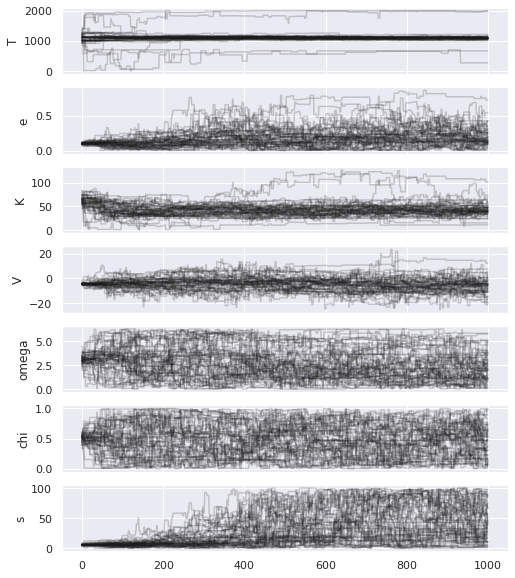

In [45]:
# This is a little function to plot the chains
def plot_chains(sampler):
    fig, ax = plt.subplots(ndim, figsize=(8, 10), sharex=True)
    for i in range(ndim):
        ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2);
        ax[i].set_ylabel(params._fields[i])

        
# PLOT YOUR CHAINS - YOUR CODE HERE
plot_chains(sampler)

## As we've seen before the initial steps in the chain aren't useful samples and it takes a while to reach a stationary distribution. Notice though that the chains are *NOT* all mixed - there are some that are wandering away from the the remaining traces, and being stubborn about it.

In [ ]:
# RUN A FULL MCMC HERE RESETING THE SAMPLER AND RESTARTING FROM THE LAST POSITION AFTER THE BURN-IN
# YOUR CODE HERE
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, 1000)

In [ ]:
# PLOT YOUR CHAINS AGAIN - YOUR CODE HERE
plot_chains(sampler)

In [ ]:
# AND LOOK AT THE PERIOD AND ECCENTRICITY 
# WE CAN'T GET MASSES FROM THE RADIAL VELOCITY METHOD, 
# BUT IF WE CARE ABOUT HABITABILITY, LOOKING AT e IS A GOOD IDEA
# Use corner.py or similar to look at the histograms
corner.corner(sampler.flatchain[:, :2], labels=params._fields[:2]);

In [ ]:
#RUN THIS TO VISUALIZE THE MODEL AGREEMENT WITH THE DATA
t_fit = np.linspace(t.min(), t.max(), 1000)

# YOUR CODE HERE
# OVERPLOT THE ORIGINAL DATA WITH YOUR FIT

plt.figure(figsize=(14, 6))
plt.errorbar(t, rv, rv_err, fmt='.k')
plt.xlabel('time (days)')
plt.ylabel('radial velocity (km/s)');

In [ ]:
# RUN THIS TO GET A SENSE OF THE PERIOD AND ECCENTRICITY
mean = sampler.flatchain.mean(0)
std = sampler.flatchain.std(0)

print("Period       = {0:.0f} +/- {1:.0f} days".format(mean[0], std[0]))
print("eccentricity = {0:.2f} +/- {1:.2f}".format(mean[1], std[1]))